In [7]:
!pip install gdown -q
!pip install easyocr -q
!pip install imutils

In [8]:
!gdown 16xsOfWZx2o58Aexq1PrQgP06YVvsMs0G

Downloading...
From (uriginal): https://drive.google.com/uc?id=16xsOfWZx2o58Aexq1PrQgP06YVvsMs0G
From (redirected): https://drive.google.com/uc?id=16xsOfWZx2o58Aexq1PrQgP06YVvsMs0G&confirm=t&uuid=2c7ca265-b6dd-4f3c-b2f8-a6a8b21a96b9
To: /kaggle/working/archive.zip
100%|█████████████████████████████████████████| 215M/215M [00:01<00:00, 118MB/s]


In [9]:
! unzip -qq archive.zip

In [168]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import join, isfile
from tqdm import tqdm
import pytesseract
import easyocr
import imutils
from sympy import symbols, simplify, latex

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F   
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import mobilenet_v2

# Data Load

In [12]:
data_train = np.load('CompleteDataSet_training_tuples.npy', allow_pickle=True)
data_val = np.load('CompleteDataSet_validation_tuples.npy', allow_pickle=True)
data_test = np.load('CompleteDataSet_testing_tuples.npy', allow_pickle=True)

In [13]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(200331, 2)
(66777, 2)
(66778, 2)


In [14]:
print(data_train[3][1])

8


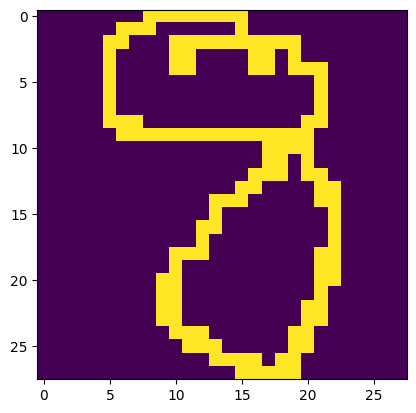

In [15]:
plt.imshow(data_train[3][0])

In [16]:
type(data_train)

numpy.ndarray

# Data Preparation

In [17]:
x_train = data_train[:, :-1]  
y_train = data_train[:, -1]

x_val = data_val[:, :-1]
y_val = data_val[:, -1]

x_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [18]:
x_test.shape

(66778, 1)

# Split data

In [19]:
x_train = np.array([[np.asarray(subarray, dtype=np.uint8) for subarray in array] for array in x_train])
x_val = np.array([[np.asarray(subarray, dtype=np.uint8) for subarray in array] for array in x_val])
x_test = np.array([[np.asarray(subarray, dtype=np.uint8) for subarray in array] for array in x_test])

In [20]:
x_test.shape

(66778, 1, 28, 28)

In [21]:
replacements = {'+': '10', '-': '11', '*': '12', '%': '13', '[': '14', ']': '15'}
v_replace = np.vectorize(lambda x: replacements.get(x, x))
y_train = v_replace(y_train).astype('float32')
y_val = v_replace(y_val).astype('float32')
y_test = v_replace(y_test).astype('float32')

In [22]:
x_train_torch = torch.from_numpy(x_train).type(torch.FloatTensor)
x_val_torch = torch.from_numpy(x_val).type(torch.FloatTensor)
x_test_torch = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train_torch = torch.from_numpy(y_train).type(torch.LongTensor)
y_val_torch = torch.from_numpy(y_val).type(torch.LongTensor)
y_test_torch = torch.from_numpy(y_test).type(torch.LongTensor)

In [23]:
x_train_torch = x_train_torch.view(-1, 1,28,28).float()
x_val_torch = x_val_torch.view(-1, 1,28,28).float()
x_test_torch = x_test_torch.view(-1, 1,28,28).float()

In [24]:
x_train_torch.shape, x_val_torch.shape, x_test_torch.shape

(torch.Size([200331, 1, 28, 28]),
 torch.Size([66777, 1, 28, 28]),
 torch.Size([66778, 1, 28, 28]))

In [25]:
train_set = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
valid_set = torch.utils.data.TensorDataset(x_val_torch, y_val_torch)
test_set = torch.utils.data.TensorDataset(x_test_torch, y_test_torch)

In [26]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = batch_size)
valid_loader = torch.utils.data.DataLoader(valid_set, shuffle = False, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_set, shuffle = False, batch_size = batch_size)

In [27]:
len(train_loader), len(valid_loader), len(test_loader)

(6261, 2087, 2087)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Models

### LeNet

In [98]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Изменилa размер после сверточных слоев
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [99]:
lenet_model = LeNet(num_classes=16).to(device)
lenet_optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
lenet_criterion = nn.CrossEntropyLoss()

### ResNet

In [100]:
resnet_model = resnet18(pretrained=False, num_classes=16).to(device)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
resnet_criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### mobilenet2

In [101]:
mobilenet_model = mobilenet_v2(pretrained=False).to(device)
mobilenet_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to(device)

mobilenet_model.classifier[1] = nn.Linear(1280, 16).to(device)

mobilenet_criterion = nn.CrossEntropyLoss()
mobilenet_optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=0.001)

### Train

In [35]:
num_epochs = 15

In [36]:
def train(model, criterion, optimizer, num_epochs, scheduler=False):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('========= Epoch %d/%d =========' % (epoch+1, num_epochs))
        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if scheduler is not False:
                scheduler.step()
            
            current_train_loss += loss.item() * inputs.size(0)
            current_train_correct += torch.sum(preds == labels)

        train_loss = current_train_loss / len(train_set)
        train_losses.append(train_loss)
        train_acc = current_train_correct / len(train_set)
        train_full_acc.append(train_acc)
        print('train loss =', train_loss)
        print('train acc = {:.2f}%'.format(train_acc.item()*100))

        # Validation
        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)
                
                current_val_correct += torch.sum(preds == labels)
                current_val_loss += val_loss.item() * inputs.size(0)

        val_acc = current_val_correct / len(valid_set)
        val_loss = current_val_loss / len(valid_set)

        print('val loss =', val_loss)
        print('val acc = {:.2f}%'.format(val_acc.item() * 100))
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

    return  train_losses, val_losses, val_full_acc, train_full_acc

In [35]:
lenet_train_loss, lenet_val_loss, lenet_valid_acc,  lenet_train_acc = train(lenet_model, lenet_criterion, lenet_optimizer, num_epochs)

========= Epoch 1/15 =========


Epoch 1/15: 100%|██████████| 6261/6261 [00:23<00:00, 267.01it/s]


train loss = 0.20502306593210967
train acc = 93.42%
val loss = 0.09467926270586882
val acc = 96.94%
========= Epoch 2/15 =========


Epoch 2/15: 100%|██████████| 6261/6261 [00:16<00:00, 383.08it/s]


train loss = 0.08150651943903896
train acc = 97.28%
val loss = 0.07026444063369135
val acc = 97.67%
========= Epoch 3/15 =========


Epoch 3/15: 100%|██████████| 6261/6261 [00:16<00:00, 389.38it/s]


train loss = 0.05894217926547007
train acc = 97.94%
val loss = 0.05558795995141016
val acc = 97.95%
========= Epoch 4/15 =========


Epoch 4/15: 100%|██████████| 6261/6261 [00:16<00:00, 385.02it/s]


train loss = 0.04812340525793297
train acc = 98.30%
val loss = 0.05058708034460619
val acc = 98.31%
========= Epoch 5/15 =========


Epoch 5/15: 100%|██████████| 6261/6261 [00:16<00:00, 389.03it/s]


train loss = 0.041726945330772196
train acc = 98.49%
val loss = 0.05391020274308512
val acc = 98.30%
========= Epoch 6/15 =========


Epoch 6/15: 100%|██████████| 6261/6261 [00:16<00:00, 389.18it/s]


train loss = 0.03828579296055018
train acc = 98.62%
val loss = 0.048182960562540275
val acc = 98.34%
========= Epoch 7/15 =========


Epoch 7/15: 100%|██████████| 6261/6261 [00:16<00:00, 383.79it/s]


train loss = 0.03465562189192936
train acc = 98.74%
val loss = 0.07470200968194936
val acc = 97.81%
========= Epoch 8/15 =========


Epoch 8/15: 100%|██████████| 6261/6261 [00:16<00:00, 383.93it/s]


train loss = 0.03243296383766492
train acc = 98.80%
val loss = 0.05789497615936696
val acc = 98.34%
========= Epoch 9/15 =========


Epoch 9/15: 100%|██████████| 6261/6261 [00:16<00:00, 382.18it/s]


train loss = 0.03068064394698109
train acc = 98.86%
val loss = 0.05223062431679261
val acc = 98.48%
========= Epoch 10/15 =========


Epoch 10/15: 100%|██████████| 6261/6261 [00:16<00:00, 382.05it/s]


train loss = 0.029099384658796662
train acc = 98.91%
val loss = 0.05315478186741262
val acc = 98.41%
========= Epoch 11/15 =========


Epoch 11/15: 100%|██████████| 6261/6261 [00:16<00:00, 387.71it/s]


train loss = 0.028617727438585237
train acc = 98.91%
val loss = 0.0622821868722015
val acc = 98.42%
========= Epoch 12/15 =========


Epoch 12/15: 100%|██████████| 6261/6261 [00:16<00:00, 377.15it/s]


train loss = 0.027920099186515418
train acc = 98.97%
val loss = 0.05723065081446832
val acc = 98.47%
========= Epoch 13/15 =========


Epoch 13/15: 100%|██████████| 6261/6261 [00:16<00:00, 383.58it/s]


train loss = 0.02751759871669115
train acc = 98.99%
val loss = 0.04880609287189085
val acc = 98.57%
========= Epoch 14/15 =========


Epoch 14/15: 100%|██████████| 6261/6261 [00:16<00:00, 378.92it/s]


train loss = 0.02594600790886121
train acc = 99.02%
val loss = 0.058506487801315274
val acc = 98.49%
========= Epoch 15/15 =========


Epoch 15/15: 100%|██████████| 6261/6261 [00:16<00:00, 384.36it/s]


train loss = 0.02594202850580066
train acc = 99.04%
val loss = 0.0555721867813153
val acc = 98.63%


In [37]:
resnet_train_loss, resnet_val_loss, resnet_valid_acc,  resnet_train_acc = train(resnet_model, resnet_criterion, resnet_optimizer, num_epochs)

========= Epoch 1/15 =========


Epoch 1/15: 100%|██████████| 6261/6261 [01:44<00:00, 59.95it/s]


train loss = 0.2069419290983541
train acc = 93.55%
val loss = 0.09959066340779762
val acc = 96.75%
========= Epoch 2/15 =========


Epoch 2/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.58it/s]


train loss = 0.10073275886105781
train acc = 96.82%
val loss = 0.07582189316054526
val acc = 97.43%
========= Epoch 3/15 =========


Epoch 3/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.41it/s]


train loss = 0.07631472689930291
train acc = 97.54%
val loss = 0.05556347182736488
val acc = 98.12%
========= Epoch 4/15 =========


Epoch 4/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.54it/s]


train loss = 0.06178217104507855
train acc = 97.89%
val loss = 0.05813881898199726
val acc = 98.10%
========= Epoch 5/15 =========


Epoch 5/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.52it/s]


train loss = 0.054986712447165666
train acc = 98.12%
val loss = 0.0502574188439401
val acc = 98.27%
========= Epoch 6/15 =========


Epoch 6/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.57it/s]


train loss = 0.04792462822983327
train acc = 98.32%
val loss = 0.051316993212825776
val acc = 98.34%
========= Epoch 7/15 =========


Epoch 7/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.50it/s]


train loss = 0.04444475558384909
train acc = 98.44%
val loss = 0.04136066316664547
val acc = 98.61%
========= Epoch 8/15 =========


Epoch 8/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.42it/s]


train loss = 0.04095657690146934
train acc = 98.50%
val loss = 0.046660056090068174
val acc = 98.31%
========= Epoch 9/15 =========


Epoch 9/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.52it/s]


train loss = 0.0388664924233239
train acc = 98.62%
val loss = 0.03897054955422452
val acc = 98.67%
========= Epoch 10/15 =========


Epoch 10/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.67it/s]


train loss = 0.036838875646773836
train acc = 98.67%
val loss = 0.04263301496055639
val acc = 98.57%
========= Epoch 11/15 =========


Epoch 11/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.42it/s]


train loss = 0.03541803506895758
train acc = 98.74%
val loss = 0.03954425216808959
val acc = 98.60%
========= Epoch 12/15 =========


Epoch 12/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.36it/s]


train loss = 0.033394626515473334
train acc = 98.76%
val loss = 0.0441847733826364
val acc = 98.50%
========= Epoch 13/15 =========


Epoch 13/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.47it/s]


train loss = 0.03220066418966838
train acc = 98.82%
val loss = 0.04054064027060129
val acc = 98.64%
========= Epoch 14/15 =========


Epoch 14/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.41it/s]


train loss = 0.031180662835899625
train acc = 98.87%
val loss = 0.04135188683810978
val acc = 98.71%
========= Epoch 15/15 =========


Epoch 15/15: 100%|██████████| 6261/6261 [01:32<00:00, 67.51it/s]


train loss = 0.029325413285366836
train acc = 98.89%
val loss = 0.04042691104429047
val acc = 98.71%


In [38]:
mobilenet_train_loss, mobilenet_val_loss, mobilenet_valid_acc, mobilenet_train_acc = train(mobilenet_model, mobilenet_criterion, mobilenet_optimizer, num_epochs)

========= Epoch 1/15 =========


Epoch 1/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.90it/s]


train loss = 0.45313770871362924
train acc = 86.31%
val loss = 0.21810546594715266
val acc = 93.78%
========= Epoch 2/15 =========


Epoch 2/15: 100%|██████████| 6261/6261 [02:23<00:00, 43.70it/s]


train loss = 0.1789124389691664
train acc = 94.83%
val loss = 0.11995163544784193
val acc = 96.21%
========= Epoch 3/15 =========


Epoch 3/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.90it/s]


train loss = 0.1264544730440225
train acc = 96.20%
val loss = 0.08630921725217588
val acc = 97.32%
========= Epoch 4/15 =========


Epoch 4/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.88it/s]


train loss = 0.10313044645799647
train acc = 96.90%
val loss = 0.07907557670402297
val acc = 97.54%
========= Epoch 5/15 =========


Epoch 5/15: 100%|██████████| 6261/6261 [02:23<00:00, 43.73it/s]


train loss = 0.08838148272488644
train acc = 97.22%
val loss = 0.07686629573548982
val acc = 97.62%
========= Epoch 6/15 =========


Epoch 6/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.83it/s]


train loss = 0.07979281272377867
train acc = 97.46%
val loss = 0.0674753935433654
val acc = 97.80%
========= Epoch 7/15 =========


Epoch 7/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.92it/s]


train loss = 0.0744383570984283
train acc = 97.63%
val loss = 0.06709304391433045
val acc = 97.82%
========= Epoch 8/15 =========


Epoch 8/15: 100%|██████████| 6261/6261 [02:22<00:00, 44.04it/s]


train loss = 0.06869246202235317
train acc = 97.76%
val loss = 0.059199749203592264
val acc = 98.09%
========= Epoch 9/15 =========


Epoch 9/15: 100%|██████████| 6261/6261 [02:23<00:00, 43.73it/s]


train loss = 0.06385249473443261
train acc = 97.90%
val loss = 0.06342753109250746
val acc = 98.01%
========= Epoch 10/15 =========


Epoch 10/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.85it/s]


train loss = 0.06099270189788407
train acc = 97.97%
val loss = 0.06353031988230087
val acc = 97.96%
========= Epoch 11/15 =========


Epoch 11/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.83it/s]


train loss = 0.05862594211492368
train acc = 98.07%
val loss = 0.05367789822270828
val acc = 98.21%
========= Epoch 12/15 =========


Epoch 12/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.88it/s]


train loss = 0.056351237906043614
train acc = 98.13%
val loss = 0.057735643695202496
val acc = 98.10%
========= Epoch 13/15 =========


Epoch 13/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.84it/s]


train loss = 0.05299101877330346
train acc = 98.20%
val loss = 0.05476123441364347
val acc = 98.15%
========= Epoch 14/15 =========


Epoch 14/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.95it/s]


train loss = 0.052090264612860995
train acc = 98.22%
val loss = 0.049820472260438974
val acc = 98.34%
========= Epoch 15/15 =========


Epoch 15/15: 100%|██████████| 6261/6261 [02:22<00:00, 43.88it/s]


train loss = 0.04984837734179955
train acc = 98.28%
val loss = 0.052663462292856324
val acc = 98.27%


In [39]:
torch.save(lenet_model.state_dict(), 'lenet.pth')
torch.save(resnet_model.state_dict(), 'resnet18.pth')
torch.save(mobilenet_model.state_dict(), 'mobilenet.pth')

### Test

In [144]:
lenet_model.load_state_dict(torch.load('/kaggle/input/models/lenet.pth'))
resnet_model.load_state_dict(torch.load('/kaggle/input/models/resnet18.pth'))
mobilenet_model.load_state_dict(torch.load('/kaggle/input/models/mobilenet.pth'))

<All keys matched successfully>

In [43]:
import gc
def test_model(model):
    model.eval()
    test_accuracy = []
    with torch.no_grad():
        total_correct = 0
        total_samples = 0 
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            gc.collect()
            torch.cuda.empty_cache()

            accuracy_test = total_correct / total_samples
            test_accuracy.append(accuracy_test)
            
    return test_accuracy

In [44]:
accuracy_lenet = test_model(lenet_model)

100%|██████████| 2087/2087 [04:03<00:00,  8.57it/s]


In [45]:
print("Test acc = {}.".format(np.mean(accuracy_lenet)))

Test acc = 0.061508901737744835.


In [46]:
accuracy_resnet = test_model(resnet_model)

100%|██████████| 2087/2087 [04:14<00:00,  8.21it/s]


In [47]:
print("Test acc = {}.".format(np.mean(accuracy_resnet)))

Test acc = 0.9867586095417817.


In [48]:
accuracy_mobilenet = test_model(mobilenet_model)

100%|██████████| 2087/2087 [04:19<00:00,  8.03it/s]


In [49]:
print("Test acc = {}.".format(np.mean(accuracy_mobilenet)))

Test acc = 0.9817269613402563.


# EasyOCR

In [102]:
image_path = '/kaggle/input/primers/test_3.png'

In [103]:
def text_extraction(image, lang_code='en'):
    reader = easyocr.Reader([lang_code])
    roi = cv2.imread(image)
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    output = reader.readtext(roi, allowlist ='0123456789[/]*+-') # text_threshold=0.9)
    # it returns list of tuple with ([x,y coordinates],text,text_threshold)
    return output

In [104]:
res = text_extraction(image_path)
res

[([[120, 121], [609, 121], [609, 238], [120, 238]],
  '2+3*46',
  0.8563305121318512)]

In [105]:
coords = res[0][0]
text = res[0][1]
prob = res[0][2]

In [106]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img = image.copy()

top_left = coords[0] # top left coordinates as tuple
bottom_right = coords[2] # bottom right coordinates as tuple

# draw rectangle on image
cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)

# write recognized text on image (top_left) minus 10 pixel on y
img_with = cv2.putText(img, text, (top_left[0], top_left[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

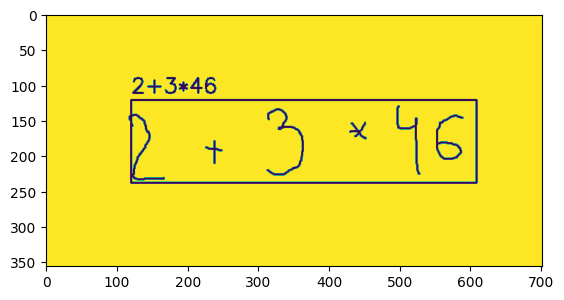

In [107]:
plt.imshow(img_with)

In [108]:
eval(text)

140

## PyTesseract tostring

Equition in  LaTeX: 2+3*16
Result of calculation: 50


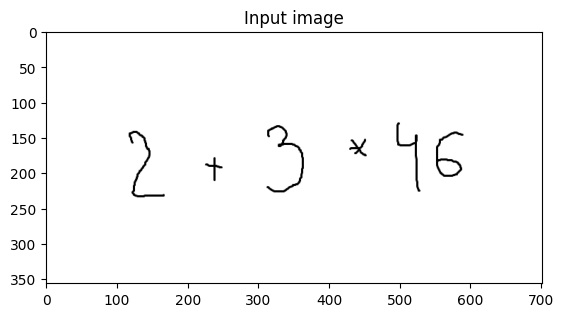

In [130]:
img = cv2.imread(image_path)

config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=]0123456789/*+-[' 
# boxes = pytesseract.image_to_boxes(output, lang= "eng", config = config)
text = pytesseract.image_to_string(img, lang='eng', config = config)

equation_str = text.strip()

x, y, z = symbols('x y z')

equation = simplify(equation_str)


print("Equition in  LaTeX:", equation_str)

result = equation.subs({x: 1, y: 2, z: 3})
print("Result of calculation:", result)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Input image")
plt.show()

## PyTesseract to boxes

In [131]:
img = cv2.imread(image_path)
output = img.copy()
string = ''
himg, wimg,_ = output.shape
config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=]0123456789/*+-[' 
boxes = pytesseract.image_to_boxes(output, lang= "eng", config = config)
bounding_boxes_list = []
for b in boxes.splitlines():
    b = b.split(" ")
    print(b)
    string += b[0] 
    x,y,w,h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
    
    x1, y1 = x, himg-y
    x2, y2 = w, himg-h
    
    bounding_boxes_list.append([x1, y1, x2, y2])
    cv2.rectangle(output, (x,himg-y), (w, himg-h),(50,50,255),1)
    cv2.putText(output, b[0], (x,himg-y+50), cv2.FONT_HERSHEY_COMPLEX,2,(50,200,50),1)
#     --psm: Page segmentation mode.
#     --oem: OCR Engine Mode. 

['2', '117', '121', '168', '215', '0']
['+', '225', '144', '250', '178', '0']
['3', '312', '128', '365', '223', '0']
['*', '429', '179', '454', '204', '0']
['1', '496', '129', '530', '227', '0']
['6', '552', '150', '591', '214', '0']


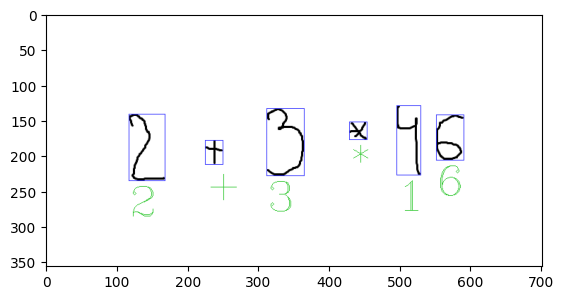

In [132]:
plt.imshow(output)

In [133]:
string, eval(string)

('2+3*16', 50)

### Crop by boxes for using models

In [145]:
def multi_plotter(arrs, preds=None):
    fig, ax = plt.subplots(1, len(arrs), figsize=(15, 10))
    for i, img in enumerate(arrs):
        ax[i].imshow(img, cmap='gray')
        if preds:
            ax[i].set_title(f'Predicted: {preds[i]}')
    plt.show()

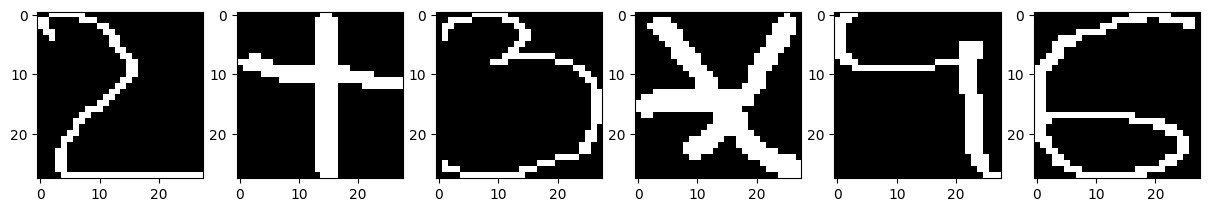

In [146]:
crops = []
for bbox in bounding_boxes_list:
    # crop by boxes
    x1, y2, x2, y1 = bbox
    crop = img[y1:y2, x1:x2] 
    dim = (28, 28)
    crop =  cv2.resize(crop, dim, interpolation = cv2.INTER_AREA)
    # from BGR 2 Gray
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # normalize and leave only > 0.5 to save gray pixels
    crop = crop/255
    crop = (crop < 0.5).astype(np.uint8)
    # append in list and show
    crops.append(crop)
multi_plotter(crops)   

## Use models to classify digits for crops

In [147]:
class_mapping = { '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, 
                 '8': 8, '9': 9, '+': 10, '-': 11, '*': 12, '%': 13, '[': 14, ']': 15}
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
    return "key doesn't exist"

In [148]:
string = ''

In [149]:
def test_model_crop(model):
    total_string = ''
    model.eval()
    with torch.no_grad():
        for img in tqdm(crops):
            img = torch.from_numpy(img.astype(np.float32)).unsqueeze(0) # batch_size x 28 x 28
            outputs = lenet_model(img.to(device))
            
            _, predicted = torch.max(outputs.data, 1)
            predicted_in_class = get_key(int(predicted.to('cpu')), class_mapping)
            total_string = total_string +  predicted_in_class
            print('Predicted', predicted_in_class )
            plt.imshow(img.squeeze())  # b_s x 28 x 28 ->> 28 x 28
            plt.show()
    return total_string

In [150]:
crops[0]

array([[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 

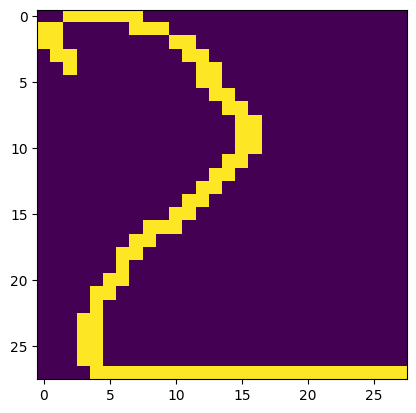

In [151]:
plt.imshow(crops[0])

In [152]:
def test_model_crop(model):
    total_string = ''
    model.eval()
    with torch.no_grad():
        for img in tqdm(crops):
            img = torch.from_numpy(img.astype(np.float32)).unsqueeze(0) # batch_size x 28 x 28
            outputs = lenet_model(img.to(device))
            
            _, predicted = torch.max(outputs.data, 1)
            predicted_in_class = get_key(int(predicted.to('cpu')), class_mapping)
            total_string = total_string +  predicted_in_class
            print('Predicted', predicted_in_class )
            plt.imshow(img.squeeze())  # b_s x 28 x 28 ->> 28 x 28
            plt.show()
 
    return total_string

## Lenet for classification

  0%|          | 0/6 [00:00<?, ?it/s]

Predicted 2


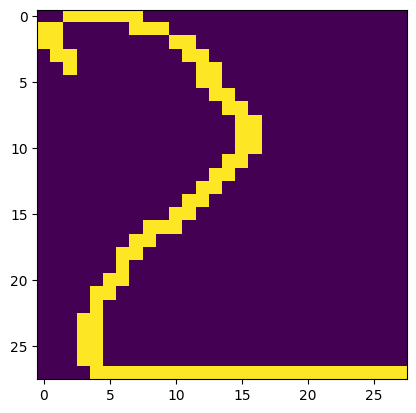

 17%|█▋        | 1/6 [00:00<00:01,  4.12it/s]

Predicted +


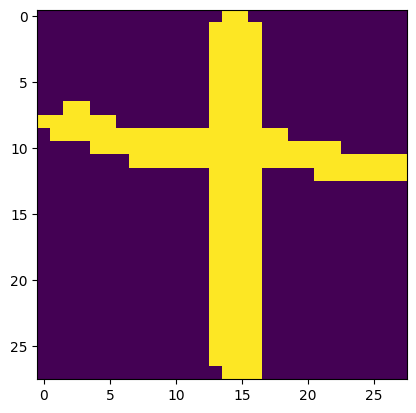

 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

Predicted 3


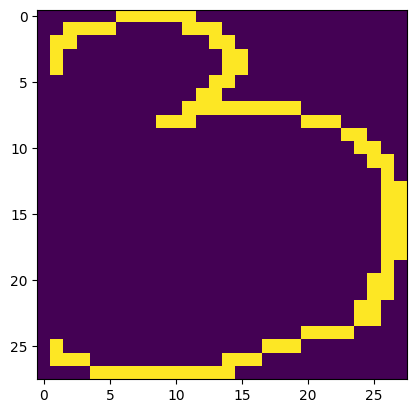

 50%|█████     | 3/6 [00:00<00:00,  3.96it/s]

Predicted *


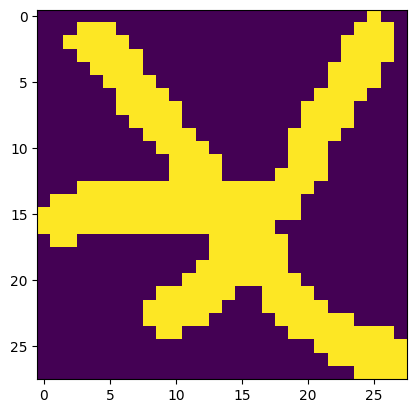

 67%|██████▋   | 4/6 [00:00<00:00,  4.08it/s]

Predicted 4


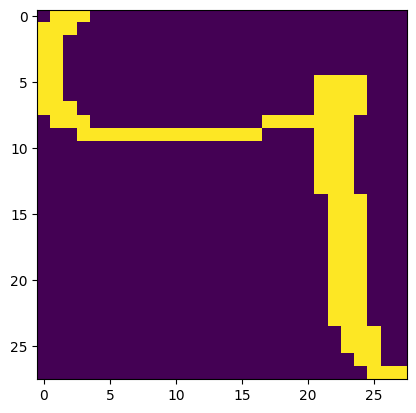

 83%|████████▎ | 5/6 [00:01<00:00,  4.22it/s]

Predicted 6


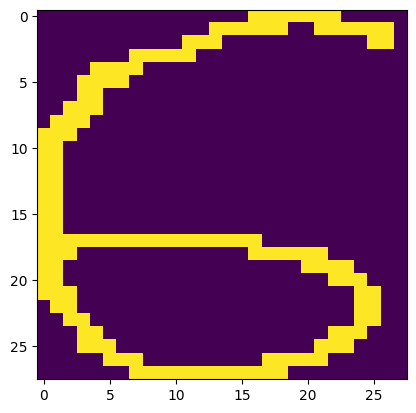

100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


In [153]:
total = test_model_crop(lenet_model)

In [154]:
total, eval(total)

('2+3*46', 140)

## ResNet18 for classification

  0%|          | 0/6 [00:00<?, ?it/s]

Predicted 2


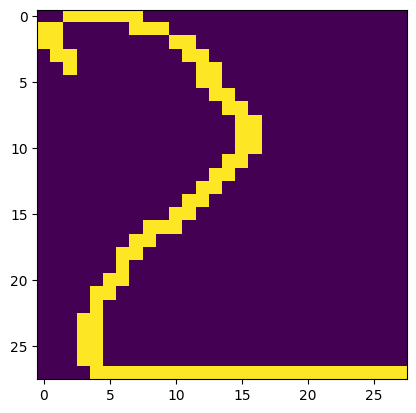

 17%|█▋        | 1/6 [00:00<00:01,  4.46it/s]

Predicted +


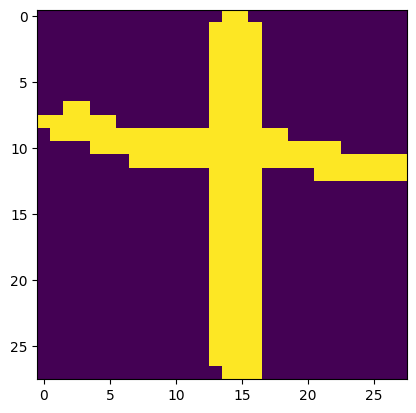

 33%|███▎      | 2/6 [00:00<00:00,  4.50it/s]

Predicted 3


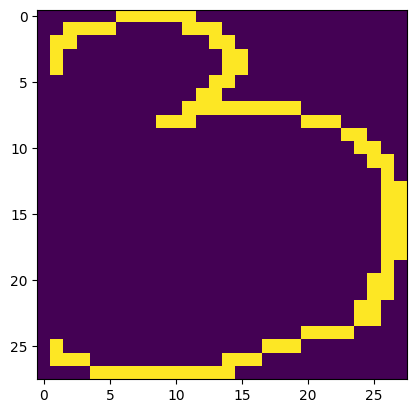

 50%|█████     | 3/6 [00:00<00:00,  4.48it/s]

Predicted *


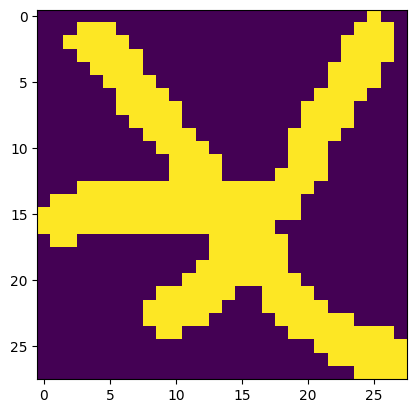

 67%|██████▋   | 4/6 [00:00<00:00,  5.04it/s]

Predicted 4


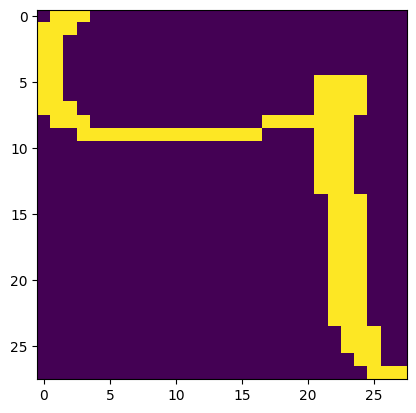

 83%|████████▎ | 5/6 [00:01<00:00,  4.86it/s]

Predicted 6


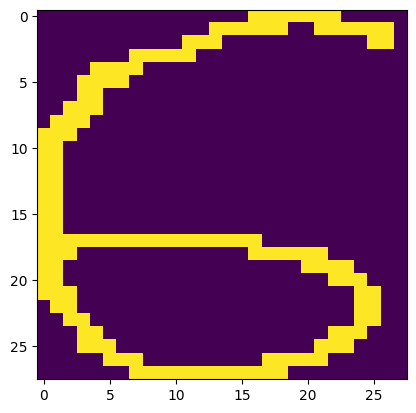

100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


In [155]:
total = test_model_crop(resnet_model)

In [156]:
total, eval(total)

('2+3*46', 140)

## MobileNet for classification

  0%|          | 0/6 [00:00<?, ?it/s]

Predicted 2


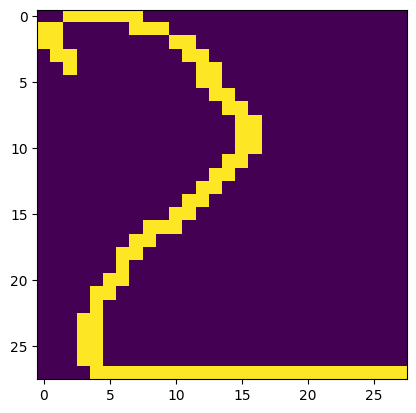

 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Predicted +


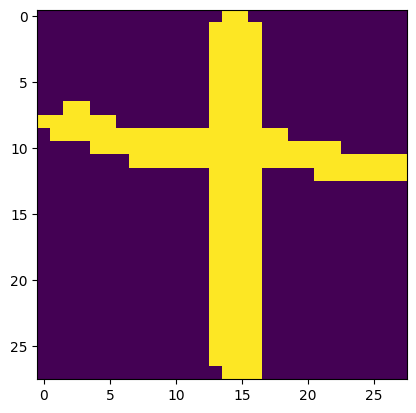

 33%|███▎      | 2/6 [00:00<00:00,  6.17it/s]

Predicted 3


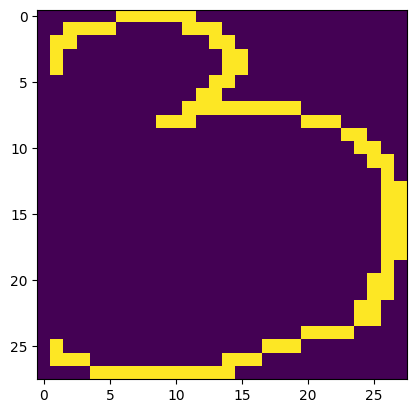

 50%|█████     | 3/6 [00:00<00:00,  6.35it/s]

Predicted *


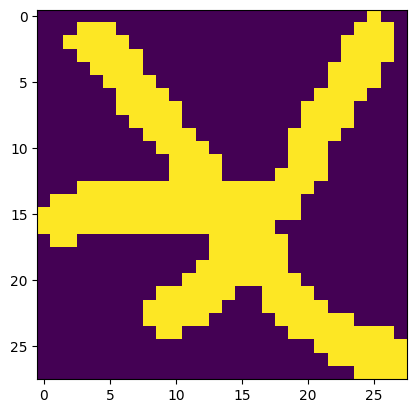

 67%|██████▋   | 4/6 [00:00<00:00,  6.44it/s]

Predicted 4


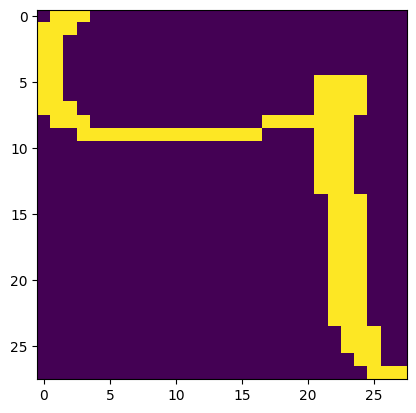

 83%|████████▎ | 5/6 [00:00<00:00,  5.97it/s]

Predicted 6


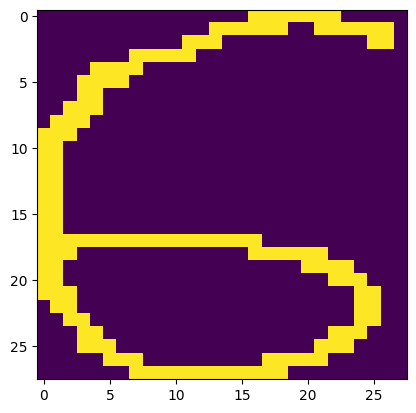

100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


In [157]:
total = test_model_crop(mobilenet_model)

In [158]:
total, eval(total)

('2+3*46', 140)

## PeTesseract to string

Equition in  LaTeX: 662
Result of calculation: 662


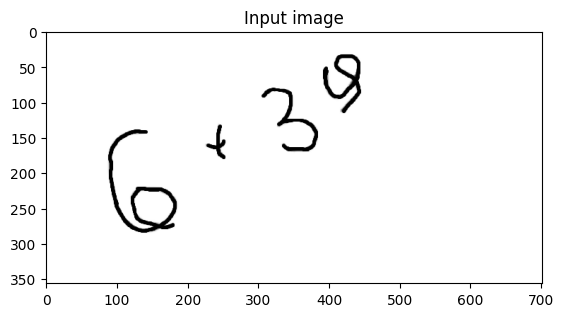

In [159]:
img = cv2.imread(image_path)

config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=]0123456789/*+-[' 
# boxes = pytesseract.image_to_boxes(output, lang= "eng", config = config)
text = pytesseract.image_to_string(img, lang='eng', config = config)

equation_str = text.strip()

x, y, z = symbols('x y z')

equation = simplify(equation_str)

print("Equition in  LaTeX:", equation_str)

result = equation.subs({x: 1, y: 2, z: 3})
print("Result of calculation:", result)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Input image")
plt.show()